In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm
from joblib import Parallel, delayed
import math
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

In [10]:
def read_csv(name):
    data = pd.read_csv(name)
    X = data[data.columns[:-1]].loc[:].values
    y = data[data.columns[-1]].loc[:].values
    return X, y

def read_dataset(num, group):
    name = "data/" + str(num).zfill(2) + "_" + group + ".csv"
    return read_csv(name)

def read_train_set(num):
    return read_dataset(num, "train")

def read_test_set(num):
    return read_dataset(num, "test")

In [11]:
def get_data_and_split(num):
    X_train, y_train = read_train_set(num)
    X_test, y_test = read_test_set(num)
    train_size = y_train.size
    test_size = y_test.size
    fold_train = np.full(train_size, -1)
    fold_test = np.full(test_size, 0)
    fold = np.concatenate((fold_train, fold_test))
    X = np.concatenate((X_train, X_test))
    y = np.concatenate((y_train, y_test))
    ps = PredefinedSplit(fold)
    return X, y, ps

def get_tree(X, y, split, max_depth_limit=15):
    params = {
        'max_depth': [x for x in range(max_depth_limit + 1)]
    }
    clf = GridSearchCV(DecisionTreeClassifier(), params, cv=split, n_jobs=-1, scoring="f1_micro", return_train_score=True)
    clf.fit(X, y)
    return clf
    
def get_tree_for_dataset(num):
    X, y, split = get_data_and_split(num)
    return get_tree(X, y, split)


In [12]:
best_trees = [get_tree_for_dataset(num) for num in tqdm(range(1, 22))]


100%|██████████| 21/21 [00:21<00:00,  1.04s/it]


In [13]:
best_depths = np.array([clf.best_params_["max_depth"] for clf in best_trees])
best_depths

array([ 3,  9,  1,  5,  1,  3,  3,  3,  4,  4,  1,  9,  7,  6,  1,  1,  7,
        5,  7,  7, 11])

In [14]:
def print_model_stats(model, title):
    xx = list(map(lambda t: t["max_depth"], model.cv_results_["params"]))
    yy_test = model.cv_results_["mean_test_score"]
    yy_train = model.cv_results_["mean_train_score"]
    plt.figure(figsize=(16,9))
    plt.grid(linestyle='--')
    plt.plot(xx, yy_test, linestyle='-',marker='.',color='r', label='Test')
    plt.plot(xx, yy_train, linestyle='-',marker='.',color='b', label='Train')
    plt.xlabel('Depth')
    plt.ylabel('Score')
    plt.title(title)
    plt.legend()
    plt.show()
    print("Best depth =", model.best_params_["max_depth"])
    print("Best score =", model.best_score_)

In [15]:
min_set = np.argmin(best_depths)
max_set = np.argmax(best_depths)

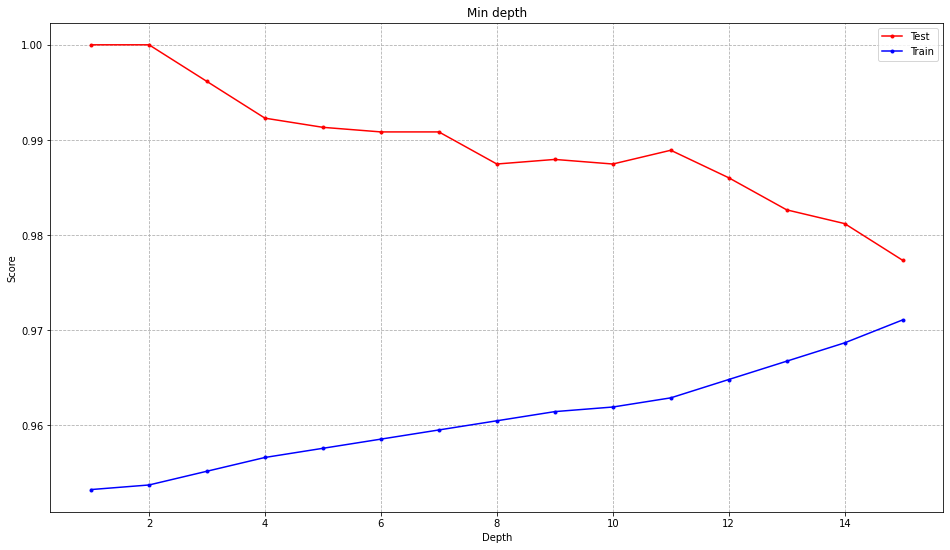

Best depth = 1
Best score = 1.0


In [16]:
print_model_stats(best_trees[min_set], "Min depth")

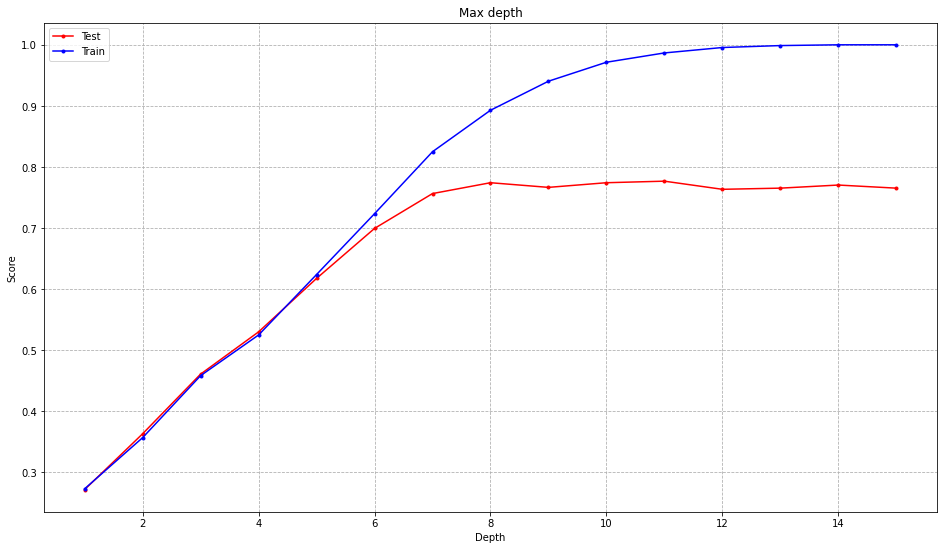

Best depth = 11
Best score = 0.7767913760304376


In [17]:
print_model_stats(best_trees[max_set], "Max depth")

In [18]:
def most_frequent_elem(elems):
    groups, counts = np.unique(elems, return_counts=True)
    return groups[np.argmax(counts)]

In [70]:
def get_random_forest(X, y, split, max_depth_limit=15):
    tree = DecisionTreeClassifier()
    param_grid = {
    }
    clf = GridSearchCV(BaggingClassifier(tree), cv=split, n_jobs=-1, scoring="f1_micro", return_train_score=True, param_grid=param_grid)
    clf.fit(X, y)
    return clf

def get_forest_for_dataset(num):
    X, y, split = get_data_and_split(num)
    return get_random_forest(X, y, split)

In [73]:
clfs = []
for num in tqdm(range(1, 22)):
    clf = get_forest_for_dataset(num)
    clfs.append(clf)
#     print(f"Dataset {num}")
#     print(f"\tTrain score {clf.cv_results_['mean_train_score']}")
#     print(f"\tTest score {clf.cv_results_['mean_test_score']}")  


100%|██████████| 21/21 [01:55<00:00,  5.48s/it]


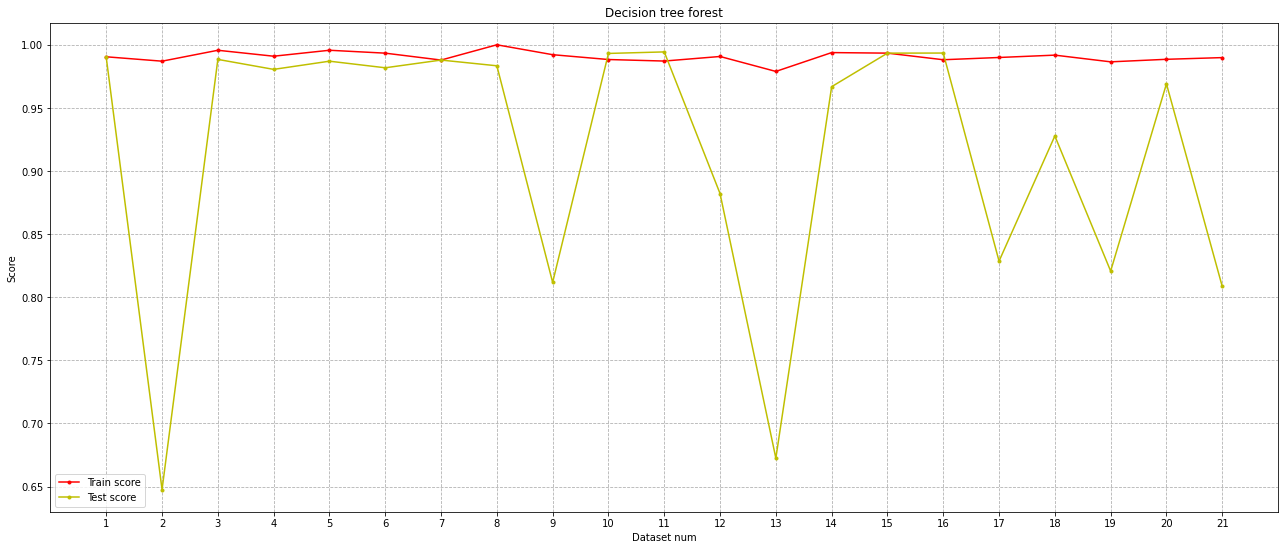

In [81]:
xx = [i for i in range(1, 22)]
yy_train = []
yy_test = []
for clf in clfs:
    yy_train.append(clf.cv_results_['mean_train_score'])
    yy_test.append(clf.cv_results_['mean_test_score'])
    
plt.figure(figsize=(22,9))
plt.grid(linestyle='--')
plt.plot(xx, yy_train, linestyle='-',marker='.',color='r', label='Train score')
plt.plot(xx, yy_test, linestyle='-',marker='.',color='y', label='Test score')
plt.xlabel('Dataset num')
plt.ylabel('Score')
plt.title('Decision tree forest')
plt.xticks(xx)
plt.legend()
plt.show()   